###Phase 1: Book Dropout Predictor
Concepts:
Binary classification, Multilayer Perceptron, PyTorch from scratch, ReLU/Sigmoid, Explainability

In [ ]:
import pandas as pd
books = pd.read_csv("books.csv")
ratings = pd.read_csv("ratings.csv")
print(books.shape)
print(ratings.shape)

(10000, 23)
(981756, 3)


Step 1:  Merge & Prepare the Dataset

In [ ]:
print("Merged columns:", merged_df.columns.tolist())
merged_df.info()
merged_df.describe(include='all')
merged_df.info()

Merged columns: ['book_id', 'user_id', 'rating', 'id', 'best_book_id', 'work_id', 'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year', 'original_title', 'title', 'language_code', 'average_rating', 'ratings_count', 'work_ratings_count', 'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'image_url', 'small_image_url']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79701 entries, 0 to 79700
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    79701 non-null  int64  
 1   user_id                    79701 non-null  int64  
 2   rating                     79701 non-null  int64  
 3   id                         79701 non-null  int64  
 4   best_book_id               79701 non-null  int64  
 5   work_id                    79701 non-null  int64  
 6   books_count                79701 non-null  int64  
 7   is

In [ ]:
selected_cols = ['average_rating', 'ratings_count', 'original_publication_year', 'books_count', 'rating']
data = merged_df[selected_cols].dropna()
data['label'] = (data['rating'] >= 4).astype(int)
data = data.drop(columns=['rating'])
data.head()

,average_rating,ratings_count,original_publication_year,books_count,label
0,4.54,1678823,2005.0,275,1
1,4.54,1678823,2005.0,275,0
2,4.54,1678823,2005.0,275,1
3,4.54,1678823,2005.0,275,1
4,4.54,1678823,2005.0,275,1


Step 2: Normalize and Split the Data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np
X = data.drop('label', axis=1).values
y = data['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)
print("X_train:", X_train_tensor.shape)
print("y_train:", y_train_tensor.shape)

X_train: torch.Size([63680, 4])
y_train: torch.Size([63680, 1])


Step 3:Define and Train the MLP

In [ ]:
import torch.nn as nn
class BookDropoutMLP(nn.Module):
    def __init__(self, input_dim):
        super(BookDropoutMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)
model = BookDropoutMLP(input_dim=4)

Step 4:Train the Model

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 20
losses = []
for epoch in range(epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/20], Loss: 0.6462
Epoch [2/20], Loss: 0.6459
Epoch [3/20], Loss: 0.6455
Epoch [4/20], Loss: 0.6452
Epoch [5/20], Loss: 0.6449
Epoch [6/20], Loss: 0.6446
Epoch [7/20], Loss: 0.6443
Epoch [8/20], Loss: 0.6440
Epoch [9/20], Loss: 0.6437
Epoch [10/20], Loss: 0.6434
Epoch [11/20], Loss: 0.6431
Epoch [12/20], Loss: 0.6428
Epoch [13/20], Loss: 0.6425
Epoch [14/20], Loss: 0.6422
Epoch [15/20], Loss: 0.6420
Epoch [16/20], Loss: 0.6417
Epoch [17/20], Loss: 0.6415
Epoch [18/20], Loss: 0.6412
Epoch [19/20], Loss: 0.6410
Epoch [20/20], Loss: 0.6408


Step 5:Plot the Loss Curve

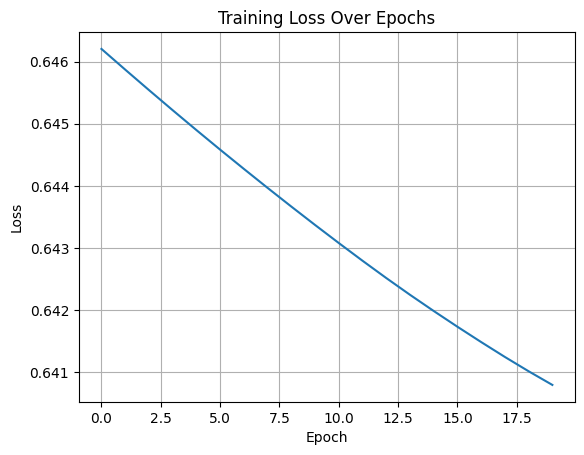

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

 Step 6: Evaluate the Model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor)
y_pred = (y_pred_probs >= 0.5).int().numpy()
y_true = y_test_tensor.numpy()
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


Accuracy:  0.6686
Precision: 0.6686
Recall:    1.0000
F1 Score:  0.8014


###Summary:

Built a binary classifier using PyTorch to predict if a user will complete a book, based on book metadata.

**Dataset**: Goodbooks-10K (books.csv + ratings.csv)  
**Label**: 1 if rating ≥ 4, else 0

**Features Used**:  
- average_rating  
- ratings_count  
- original_publication_year
- books_count

**Model**:  
- MLP with 2 hidden layers (ReLU), final Sigmoid layer  
- Trained for 20 epochs using Binary Cross Entropy + Adam

**Results**:
- Accuracy: 66.86%  
- Precision: 66.86%  
- Recall: 100%  
- F1 Score: 80.14%

 No data leakage,rating not used as input. All results from real metadata.
